In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

In [2]:
rcParams['figure.figsize'] = 16,4

## 读取数据

In [3]:
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
dot_data_1 = pd.read_excel(path + '20190103_点部取货量_1.xlsx', parse_dates=[1])
dot_data_2 = pd.read_excel(path + '20190103_点部取货量_2.xlsx', parse_dates = [1])

In [4]:
dot_data = pd.concat([dot_data_1,dot_data_2],ignore_index = True)

## 数据预处理

In [5]:
data = dot_data.copy()
data = data.drop(['num', 'jifei_weight', 'shiji_weight', 'longitude', 'latitude'], axis = 1)

In [6]:
data_ts = data.copy()
data_ts.index = data['order_date']
data_ts.head()

,dot,order_date,order_num
order_date,,,
2017-05-23,13825092291,2017-05-23,1
2017-06-06,15102680258,2017-06-06,1
2017-06-09,ERP客户系统组,2017-06-09,1
2017-04-13,IT采购组,2017-04-13,8
2017-05-03,IT采购组,2017-05-03,4


In [7]:
data_ts.sort_index(ascending = True, inplace = True)
tmp = data_ts['2017-11':]
tmp.head()

,dot,order_date,order_num
order_date,,,
2017-11-01,松江新桥点部,2017-11-01,113
2017-11-01,成都公兴点部,2017-11-01,3
2017-11-01,宁海桃源点部,2017-11-01,61
2017-11-01,海口龙华点部,2017-11-01,5
2017-11-01,温州娄桥点部,2017-11-01,110


In [8]:
data_count = pd.DataFrame(tmp['order_date'].groupby(tmp['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 360, ['dot']]
useful_dot_name.head()

,dot
31,上虞上浦点部
32,上虞东关点部
36,上虞小越点部
38,上虞崧厦点部
58,东丽中心庄点部


In [9]:
result_data = tmp.loc[tmp['dot'].isin(useful_dot_name['dot'])]
result_data.head()

,dot,order_date,order_num
order_date,,,
2017-11-01,宁海桃源点部,2017-11-01,61
2017-11-01,温州娄桥点部,2017-11-01,110
2017-11-01,寮步凫山点部,2017-11-01,16
2017-11-01,惠山玉祁点部,2017-11-01,31
2017-11-01,金陵光华门点部,2017-11-01,8


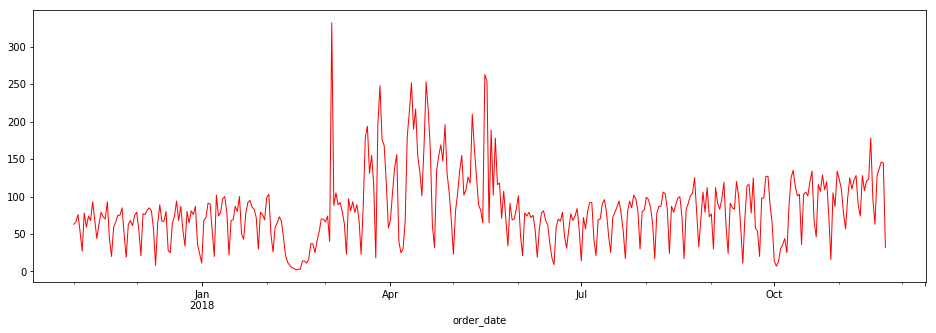

In [10]:
result_ts = result_data.loc[result_data['dot'] == '坂田清湖点部', ['order_num']]   # 盛泽黎星点部,常熟莫城点部
# result_ts_log = np.log(result_ts)
result_ts = result_ts['order_num'].resample('D').sum()
result_ts.plot(figsize = (16,5), color = 'r', linewidth=1)

## 数据拆分

In [11]:
result_ts_train = result_ts[0 : -30]
result_ts_test = result_ts[-30 : ]
result_ts_test.head(2).append(result_ts_test.tail(2))

order_date
2018-10-25    109
2018-10-26    120
2018-11-22    145
2018-11-23     32
Name: order_num, dtype: int64

## 数据检验

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(result_ts_train, model = "additive")
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

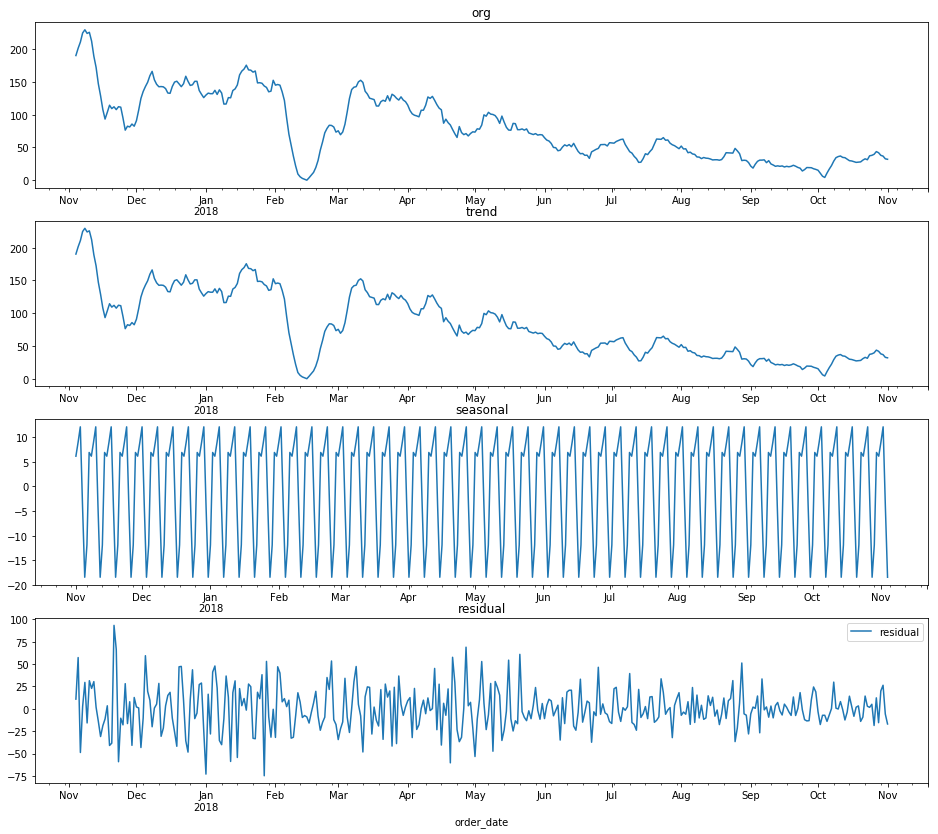

In [44]:
fig = plt.figure(figsize = (16,14))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
trend.plot(label = 'org', ax = ax1, title = 'org')
trend.plot(label = 'trend', ax = ax2, title = 'trend')
seasonal.plot(label = 'seasonal', ax = ax3, title = 'seasonal')
residual.plot(label = 'residual', ax = ax4, title = 'residual')
plt.legend(loc = 'best')

## 白噪声检验

In [45]:
from statsmodels.stats.diagnostic import acorr_ljungbox
def test_stochastic(ts,lag):
    p_value = acorr_ljungbox(ts, lags=lag) #lags可自定义
    return p_value
test_stochastic(result_ts_train,1)

(array([232.72607262]), array([1.51651423e-52]))

## 数据平稳检测

In [46]:
dftest = adfuller(result_ts_train)
output = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    output['Critical Value (%s)' % key] = value
output

Test Statistic                  -2.233186
p-value                          0.194422
#Lags Used                      15.000000
Number of Observations Used    353.000000
Critical Value (1%)             -3.449011
Critical Value (5%)             -2.869763
Critical Value (10%)            -2.571151
dtype: float64

Text(0.5,1,'Partial Autocorrelation Function')

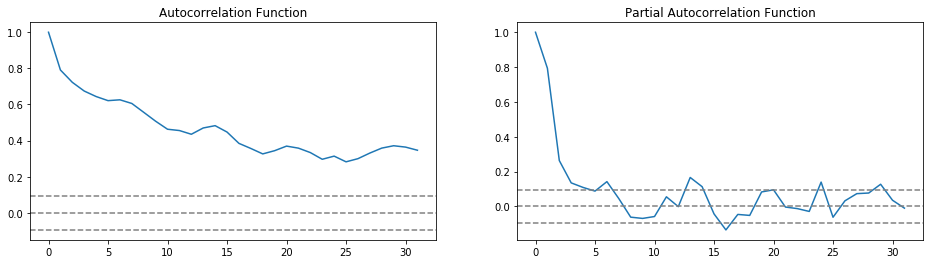

In [47]:
lag_acf = acf(result_ts_train, nlags = 31)
lag_pacf = pacf(result_ts_train, nlags = 31)

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(result_ts)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(result_ts)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(result_ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(result_ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')


In [48]:
import warnings
warnings.filterwarnings("ignore")
p=d=q=range(0,2)
pdq=list(itertools.product(p,d,q))
seasonal_pdq=[(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#选择最优参数
param_best=0
param_seasonal_best=0
aic_best = np.inf
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(result_ts_train,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
            results = mod.fit()
            if results.aic<aic_best:
                param_best=param
                param_seasonal_best=param_seasonal
                aic_best=results.aic
        except:
            continue
print(param_best, param_seasonal_best)

(1, 1, 1) (1, 1, 1, 12)


In [49]:
#预测
mod=sm.tsa.statespace.SARIMAX(result_ts_train,
                            order=param_best,
                            seasonal_order=param_seasonal_best,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
sarimax_model=mod.fit()

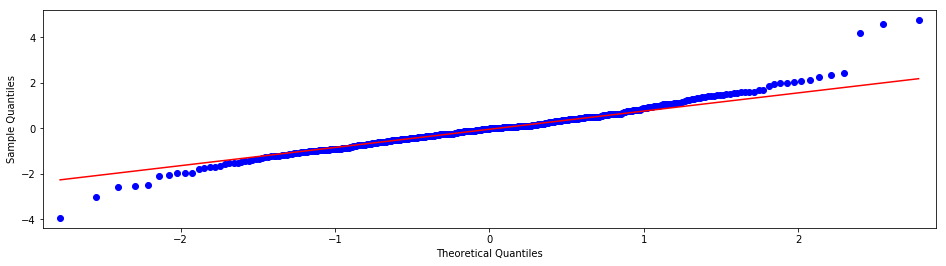

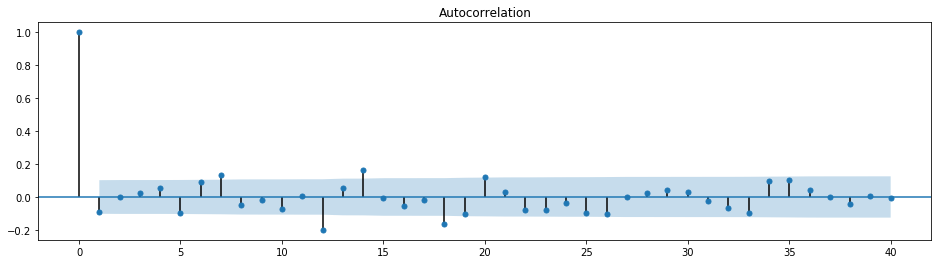

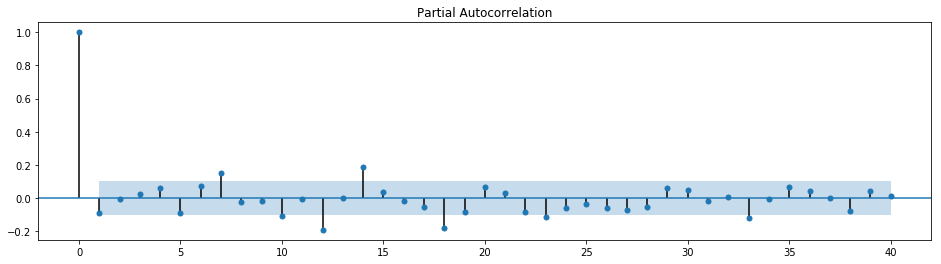

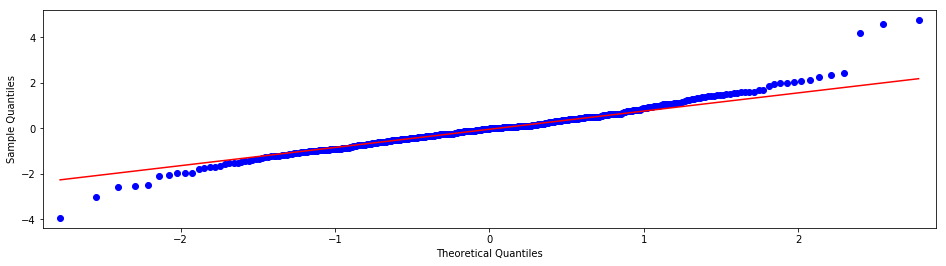

In [50]:
from statsmodels.graphics.api import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
resid = sarimax_model.resid
plot_acf(resid.squeeze(), lags=40)
plot_pacf(resid, lags=40)
qqplot(resid, line='q', fit=True)

In [51]:
sarimax_result_train = sarimax_model.predict()

Text(0.5,1,'TRAIN_RSME : 39.2271')

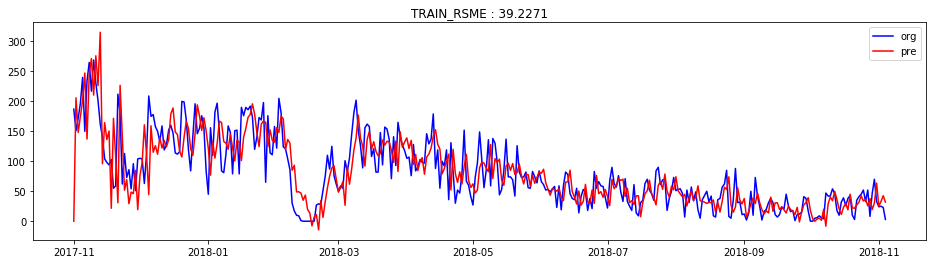

In [52]:
plt.plot(result_ts_train, label = 'org', color = 'b')
plt.plot(sarimax_result_train, label = 'pre', color = 'r')
plt.legend(loc = 'best')
plt.title("TRAIN_RSME : %.4f" % np.sqrt(np.sum((sarimax_result_train - result_ts_train) ** 2)/len(result_ts_train)))

In [53]:
sarimax_result_test = sarimax_model.predict(result_ts_test.index[0].strftime('%Y-%m-%d'), result_ts_test.index[-1].strftime('%Y-%m-%d'), dynamic = True)

Text(0.5,1,'TRAIN_RSME : 28.4342')

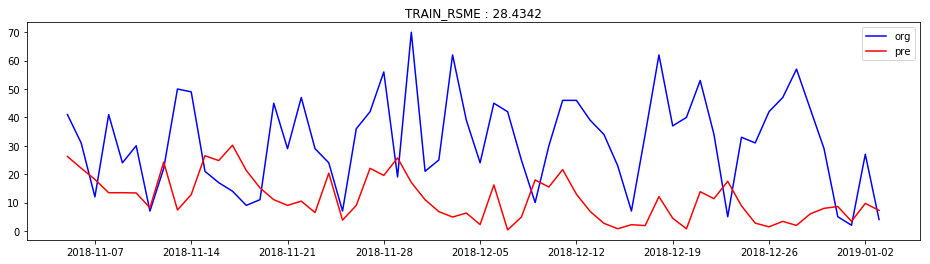

In [54]:
plt.plot(result_ts_test, label = 'org', color = 'b')
plt.plot(abs(sarimax_result_test), label = 'pre', color = 'r')
plt.legend(loc = 'best')
plt.title("TRAIN_RSME : %.4f" % np.sqrt(np.sum((sarimax_result_test - result_ts_test) ** 2)/len(result_ts_test)))

In [55]:
accurate=[]
for i in range(len(sarimax_result_test)):
     accurate.append(min(sarimax_result_test[i], result_ts_test[i])/max(sarimax_result_test[i], result_ts_test[i]))
accurate = pd.DataFrame(accurate, index = result_ts_test.index, columns = ['acc_rate'])
# print("Mean acc_rate : %.4f" % accurate.acc_rate.mean())
accurate

,acc_rate
order_date,
2018-11-05,0.640197
2018-11-06,0.712862
2018-11-07,0.661523
2018-11-08,0.328039
2018-11-09,0.561057
2018-11-10,0.445861
2018-11-11,0.861674
2018-11-12,0.906987
2018-11-13,0.147699
